Hint: tham khảo tại https://nlp.seas.harvard.edu/annotated-transformer/#position-wise-feed-forward-networks

# Bài 1: Xây dựng các thành phần của transformer từ đầu

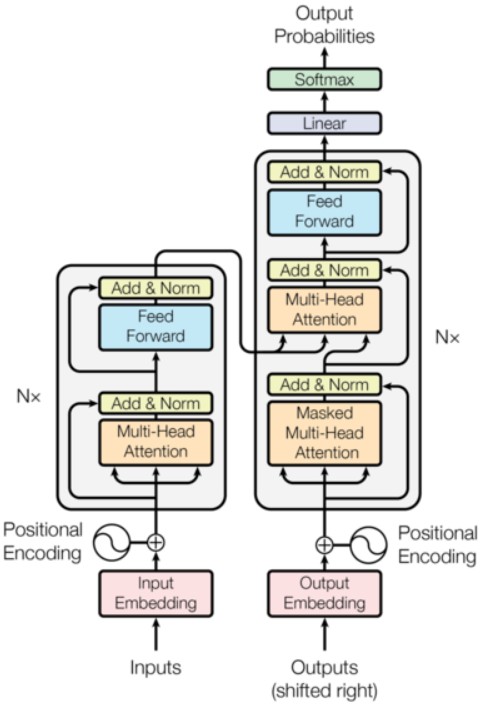

## Multihead Attention

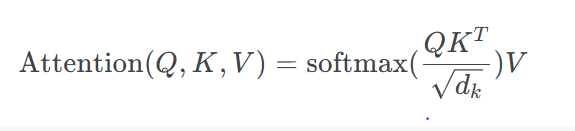

In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import copy

In [ ]:
def attention(q, k, v, mask=None, dropout=None):
    d_k = q.shape[-1]
    attn_score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        attn_score = attn_score.masked_fill(mask == 0, -1e9)
    attn_weights = torch.softmax(attn_score, dim=-1)
    if dropout is not None:
        attn_weights = dropout(attn_weights)
    output = torch.matmul(attn_weights, v)
    return output, attn_weights

In [ ]:
def clones(module, N):
    return nn.ModuleList([module for _ in range(N)])

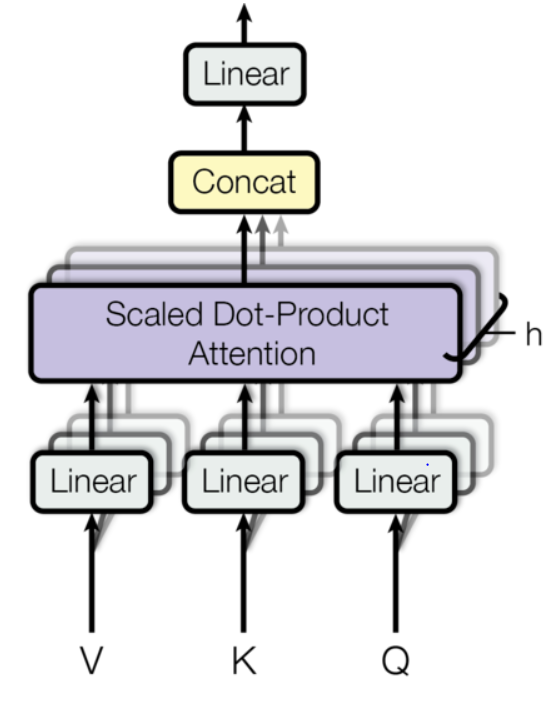

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.kv_proj = nn.Linear(embed_dim, embed_dim * 2)
        self.fc_out = nn.Linear(self.embed_dim, embed_dim)
    def forward(self, values, keys, query, mask):
        B, T, C = query.shape
        # split heads
        if mask is not None:
            mask = mask.unsqueeze(1)
        q_proj = self.q_proj(query)
        kv_proj = self.kv_proj(keys)
        q = q_proj.view(B, T, self.heads, self.head_dim)
        kv = kv_proj.view(B, T, self.heads, self.head_dim)
        k, v = kv.chunk(2, dim=-1)
        attn_score, attn_weights = attention(q, k, v, mask)
        attn_score = attn_score.transpose(1, 2).contiguous().view(B, T, self.embed_dim)
        out = self.fc_out(attn_score)
        del q, k, v
        return out, attn_weights




## Embedding

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.lut = nn.Embedding(vocab_size, embed_dim)
        self.d_model = embed_dim 
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pos = torch.arange(max_len).unsqueeze(1)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.shape[1], :]

## Layer Normalization

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.scale = nn.Parameter(torch.ones(embed_dim))
        self.bias = nn.Parameter(torch.zeros(embed_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.scale * (x - mean) / (std + 1e-9) + self.bias

## Sublayer Connection

Residual Connection + Layer Norm

In [ ]:
class SublayerConnection(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## Position-wise Feed-Forward Networks

Sử dụng kích hoạt Relu

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.expansion_factor = expansion_factor
        self.fc1 = nn.Linear(embed_dim, embed_dim * expansion_factor)
        self.fc2 = nn.Linear(embed_dim * expansion_factor, embed_dim)
    def forward(self, x):
        return self.fc2(torch.nn.functional.gelu(self.fc1(x)))

## Encoder layer và Encoder



In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size 
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layers, N):
        super().__init__()
        self.layers = clones(layers, N)
        self.norm = LayerNorm(layers.size)
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


## Decoder và Decoder layor

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, cross_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.cross_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
            

## Encoder-Decoder

In [ ]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [ ]:
def make_model(
    src_vocab,
    tgt_vocab,
    N=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=0.1,
):
    """Helper: Construct a model from hyperparameters."""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Bài 2: Áp dụng transformer cho bài toán phân loại cảm xúc sử dụng bộ dữ liệu IMDB

# Bài 3: Áp dụng transformer cho bài toán dịch Anh-Việt (dataset: https://github.com/KCDichDaNgu/KC4.0_MultilingualNMT.git)